In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import pylatexenc

import numpy as np
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")


# Oracle for Shor's Algorithm

Following Beauregard's [Circuit for Shor’s algorithm using $2n+3$ qubits](https://arxiv.org/pdf/quant-ph/0205095).

## Quantum Fourier Transform

We can use qiskit's own [synt_qft_full](https://quantum.cloud.ibm.com/docs/en/api/qiskit/synthesis#synth_qft_full):

In [2]:
from qiskit.synthesis.qft import synth_qft_full

For inverse use the `synth_qft_full`'s optional argument `inverse=True`.

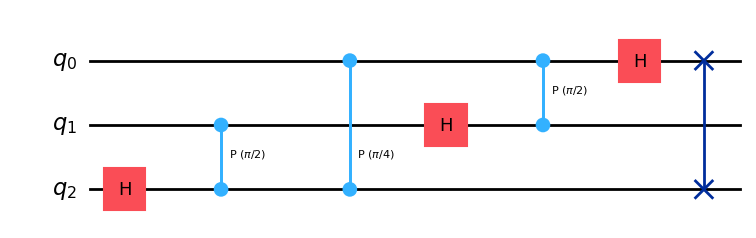

In [3]:
synth_qft_full(num_qubits=3).draw("mpl")

In [4]:
psi2 = Statevector(synth_qft_full(3))
probs2 = np.round(psi2.probabilities(), 4)
probs2

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

## Draper Adder Gate

In [5]:
def draper_adder(k, n):
    """
    FIXME:
    """
    quantum_register = QuantumRegister(size=n, name="x")
    draper_adder_circuit = QuantumCircuit(quantum_register, name=f"{k} adder")

    draper_adder_circuit.compose(synth_qft_full(n), inplace=True)

    # draper_adder_circuit.barrier()

    # phaser part
    for idx, q in enumerate(reversed(quantum_register)):
        draper_adder_circuit.p(np.pi * k / (1 << idx), q)

    # draper_adder_circuit.barrier()

    draper_adder_circuit.compose(synth_qft_full(n, inverse=True), inplace=True)

    return draper_adder_circuit

Testing:

In [6]:
k, n = 7, 4

psi = Statevector(draper_adder(k, n))
probs = np.round(psi.probabilities(), 4)
res = int(np.sum(probs * np.arange(2 ** n)))
res == k

True

Let's test if further:

In [7]:
def binary_digits(a, n):
    """
    Returns a binary representation of a in n-bits.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


def set_a(a, n):
    """
    Returns a circuit in n qubits that takes |0> to |a>.
    """
    quantum_register = QuantumRegister(size=n, name="x")
    binary_repres = binary_digits(a, n)

    a_setter_circuit = QuantumCircuit(quantum_register, name=f"{a} setter")

    for digit, q in zip(binary_repres, quantum_register):
        if digit:
            a_setter_circuit.x(q)

    return a_setter_circuit


In [8]:
a, k, n = 2, 7, 10

psi = Statevector(set_a(a, n).compose(draper_adder(k, n)))
probs = np.round(psi.probabilities(), 4)
res = int(np.sum(probs * np.arange(2 ** n)))
res == a + k

True

---

Alternatively, use qiskit's [DraperQFTAdder](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.DraperQFTAdder):  (**HOW?**)

In [9]:
from qiskit.circuit.library import DraperQFTAdder

In [10]:
def a_b_adder(a, b, n):
    # adder = QuantumCircuit(2 * n)
    # adder.compose(quantum_fourier_transform(2 * n), inplace=True)
    # adder.compose(DraperQFTAdder(n), inplace=True)
    # adder.compose(inverse_quantum_fourier_transform(2 * n), inplace=True)

    quantum_register_a = QuantumRegister(size=n, name="a")
    quantum_register_b = QuantumRegister(size=n, name="b")

    test_adder_a_plus_b = QuantumCircuit(
        quantum_register_a, quantum_register_b, name=f"{a} + {b}"
    )

    a_gate = set_a(a, n).to_gate(label=f"set {a}")
    b_gate = set_a(b, n).to_gate(label=f"set {b}")

    test_adder_a_plus_b.compose(a_gate, quantum_register_a, inplace=True)
    test_adder_a_plus_b.compose(b_gate, quantum_register_b, inplace=True)
    test_adder_a_plus_b.compose(synth_qft_full(n), quantum_register_b, inplace=True)
    test_adder_a_plus_b.compose(DraperQFTAdder(n), inplace=True)
    test_adder_a_plus_b.compose(synth_qft_full(n, inverse=True), quantum_register_b, inplace=True)
    return test_adder_a_plus_b

def test_adder(a, b, n):
    test_adder_a_plus_b = a_b_adder(a, b, n)
    psi = Statevector(test_adder_a_plus_b)
    return np.round(psi.probabilities(), 8)

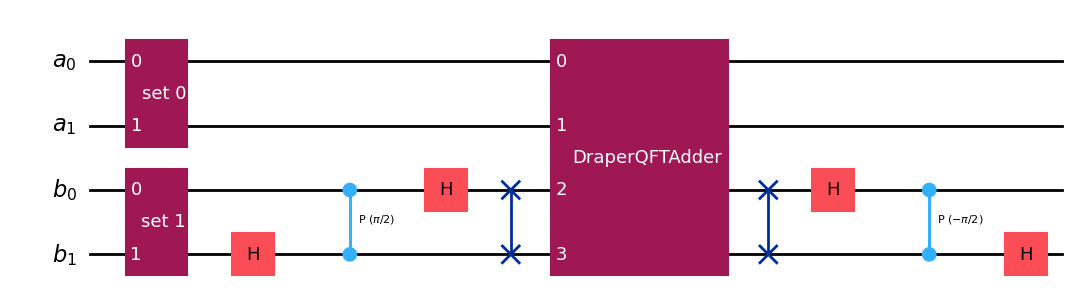

In [11]:
a_b_adder(0, 1, 2).draw("mpl")

In [12]:
test_adder(0, 0, 2)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
test_adder(1, 0, 2)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
test_adder(0, 1, 2)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
test_adder(2, 0, 2)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
test_adder(1, 1, 2)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
test_adder(0, 2, 2)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
test_adder(2, 3, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
test_adder(1, 0, 3)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
test_adder(0, 1, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
test_adder(2, 0, 3)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
test_adder(1, 1, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
test_adder(0, 2, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

---

## Modular Adder Gate

In [24]:
def modular_adder(a, N):
    """
    FIXME:
    """

    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=2, name="c")
    quantum_register = QuantumRegister(size=n + 1, name="x")  # note the "+1"!
    last_register = QuantumRegister(size=1, name="l")

    mod_adder_circ = QuantumCircuit(
        control_register, quantum_register, last_register, name=f"Add({a})_Mod({N})"
    )

    # qft = quantum_fourier_transform(n + 1).to_gate(label="qft")
    # qft_inv = inverse_quantum_fourier_transform(n + 1).to_gate(label="qft_inv")

    add_a_gate = draper_adder(a, n + 1).to_gate(label=f"add_{a}")
    add_a_gate_inv = draper_adder(a, n + 1).inverse().to_gate(label=f"sub_{a}")
    c_add_a_gate = add_a_gate.control(2)
    c_add_a_gate_inv = add_a_gate_inv.control(2)

    add_N_gate = draper_adder(N, n + 1).to_gate(label=f"add_{N}")
    add_N_gate_inv = draper_adder(N, n + 1).inverse().to_gate(label=f"sub_{N}")
    c_add_N_gate = add_N_gate.control(1)

    # mod_adder_circ.compose(qft, quantum_register, inplace=True)
    mod_adder_circ.compose(c_add_a_gate, range(n + 3), inplace=True)
    mod_adder_circ.compose(add_N_gate_inv, quantum_register, inplace=True)
    # mod_adder_circ.compose(qft_inv, quantum_register, inplace=True)
    mod_adder_circ.cx(-2, -1)
    # mod_adder_circ.compose(qft, quantum_register, inplace=True)
    mod_adder_circ.compose(c_add_N_gate, [-1] + list(range(2, n + 3)), inplace=True)
    mod_adder_circ.compose(c_add_a_gate_inv, range(n + 3), inplace=True)
    mod_adder_circ.x(-2)
    mod_adder_circ.cx(-2, -1)
    mod_adder_circ.x(-2)
    mod_adder_circ.compose(c_add_a_gate, range(n + 3), inplace=True)

    return mod_adder_circ

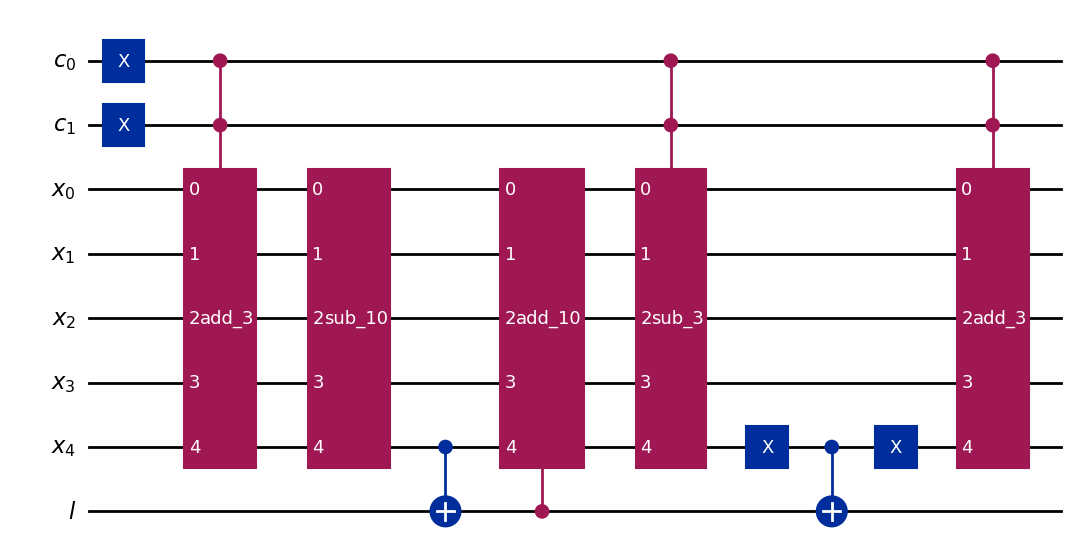

In [25]:
a, N = 3, 10

n = int(np.ceil(np.log2(N)))

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage
mod_adder.compose(modular_adder(a, N), inplace=True)
mod_adder.draw(output="mpl")

In [26]:
psi = Statevector(mod_adder)
probs = np.round(psi.probabilities(), 4)

Since we've set $(c_0, c_1) = (1, 1)$ to run, we need to subtract $1 + 1 \cdot 2 = 3$ and divide by $2^2$ to get the result.

In [27]:
res = int((np.sum(probs * np.arange(2 ** (n + 4))) - 3) // 4)
res == a

True

Now, let's add another number:

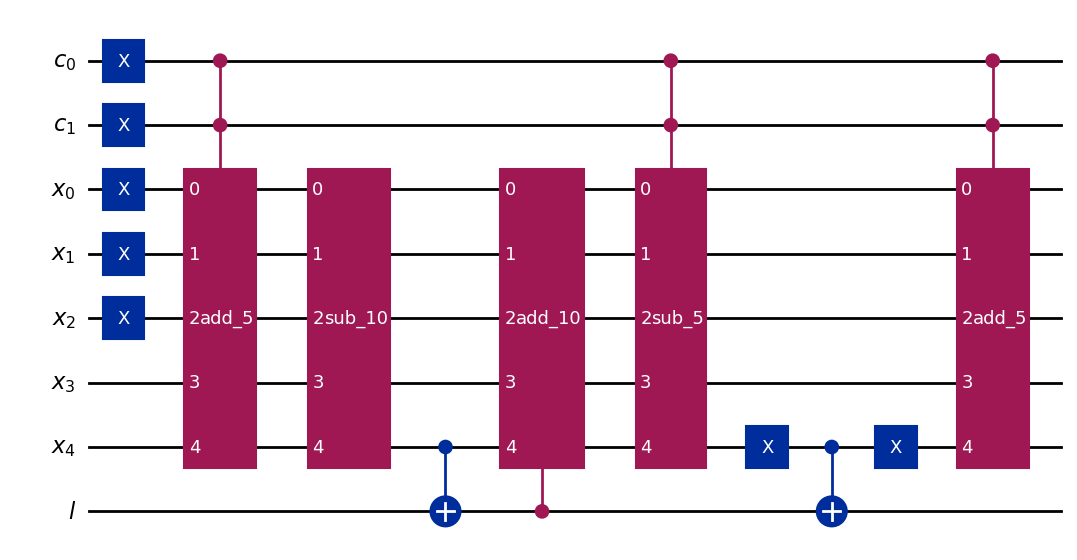

In [28]:
a = 5
N = 10
n = int(np.ceil(np.log2(N)))

b = 7

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage
mod_adder.compose(set_a(b, n + 1), quantum_register, inplace=True)
mod_adder.compose(modular_adder(a, N), inplace=True)
mod_adder.draw(output="mpl")


In [29]:
psi = Statevector(mod_adder)
probs = np.round(psi.probabilities(), 4)

res = int((np.sum(probs * np.arange(2 ** (n + 4))) - 3) // 4)
res == (a + b) % N

True

**IMPORTANT:**  The `a` and `b` above must be in $\{0, 1, 2, \ldots, N\}$:

In [30]:
a = 0
N = 30
n = int(np.ceil(np.log2(N)))

b = 30

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage
mod_adder.compose(set_a(b, n + 1), quantum_register, inplace=True)
mod_adder.compose(modular_adder(a, N), inplace=True)
# mod_adder.draw(output="mpl")

psi = Statevector(mod_adder)
probs = np.round(psi.probabilities(), 4)

res = int((np.sum(probs * np.arange(2 ** (n + 4))) - 3) // 4)
res == (a + b) % N

False

In [31]:
(res, (a + b) % N)

(64, 0)

## The Controlled Multiplier

In [32]:
def modular_mult(a, N):
    """
    FIXME:
    """

    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    adder_register = QuantumRegister(size=n + 2, name="b")

    mod_mult_circ = QuantumCircuit(
        control_register, quantum_register, adder_register, name=f"Mult({a})_Mod({N})"
    )

    for i in range(n):
        mod_mult_circ.compose(
            modular_adder((a * 2**i) % N, N),  #  IS THIS LEGAL????
            [0] + [i + 1] + list(range(n + 1, 2 * n + 3)),
            inplace=True,
        )

    return mod_mult_circ

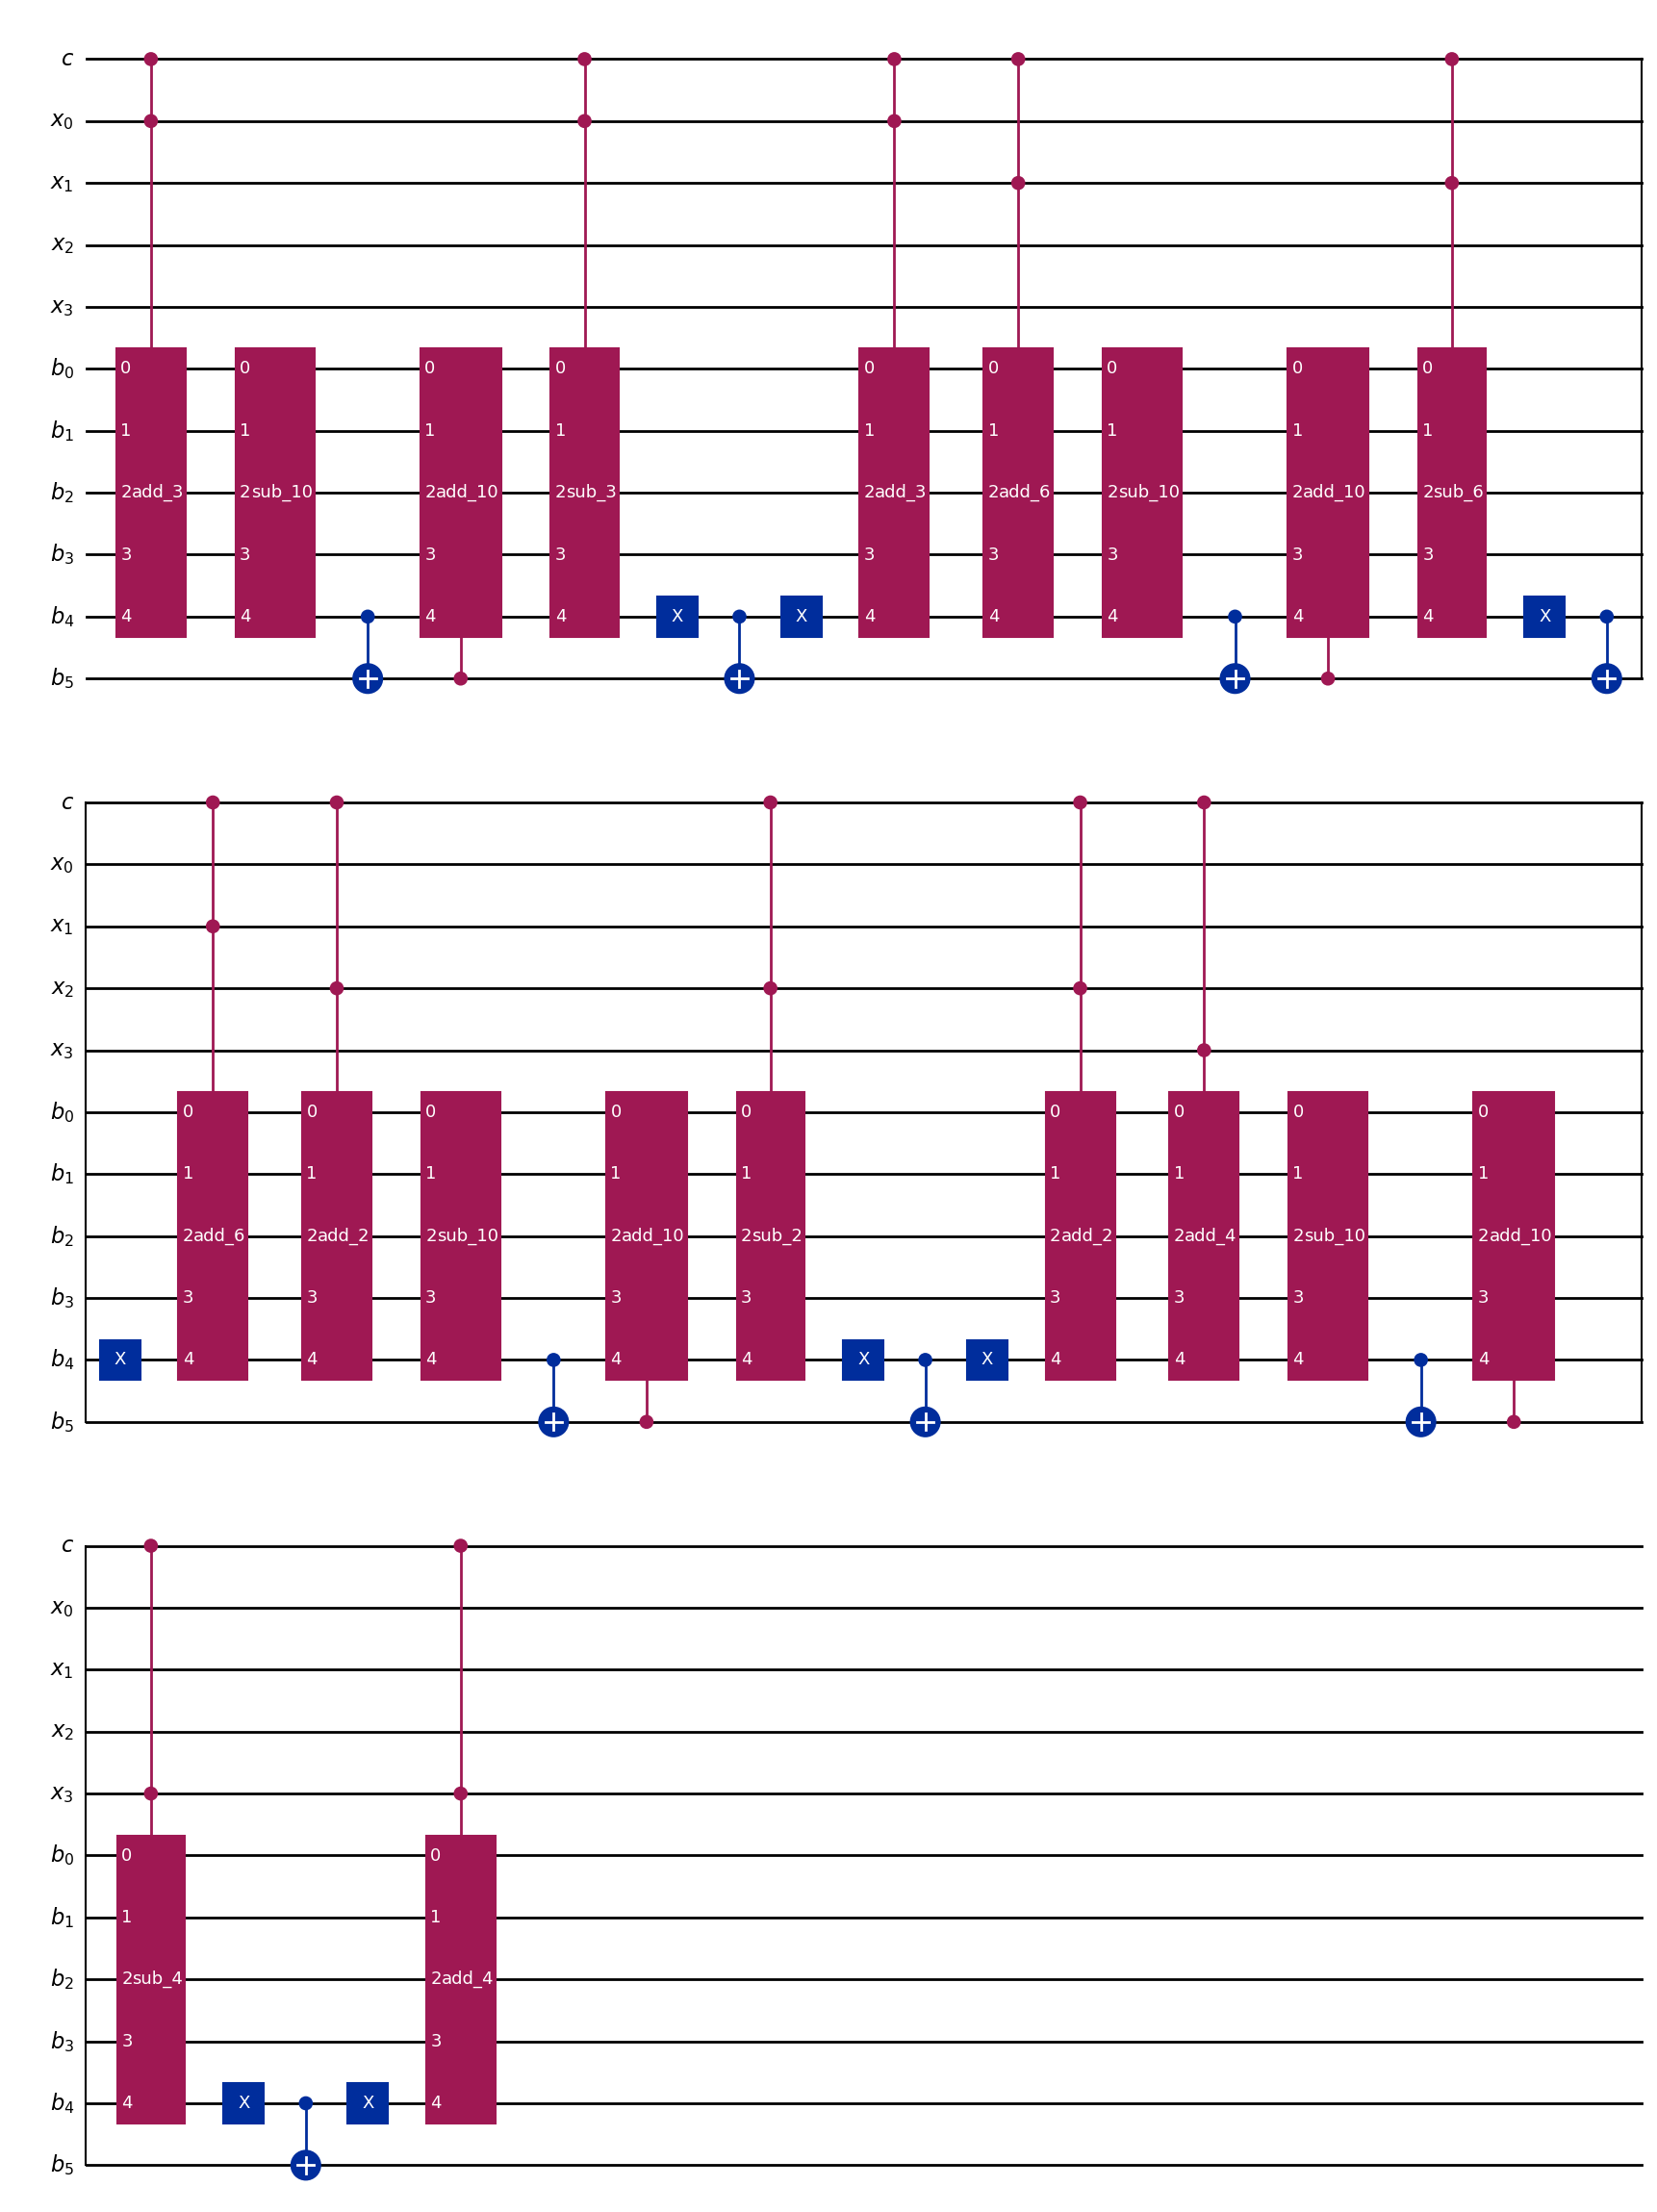

In [33]:
a = 3
N = 10
modular_mult(a, N).draw("mpl")

Test with control equal to $1$:

In [34]:
a = 4
N = 15

b = 5
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

(res - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

# mod_multiplier.draw(output="mpl")

True

Test with control equal to zero:

In [35]:
# CONTROL IS ZERO!!!!!!

a = 4
N = 15

b = 7
x = 10

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

# mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

res == x * 2 + b * (2 ** (n + 1))

# mod_multiplier.draw(output="mpl")

True

Test with $2^{n-1} \leq N \leq x < 2^n$:

In [36]:
a = 4
N = 20

b = 0
x = 22

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

# (res - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

# mod_multiplier.draw(output="mpl")

In [37]:
res

557.0

Here is a version that does not use classical computation of $a \cdot 2^k$ modulo $N$:

In [38]:
def modular_mult_2(a, N):
    """
    FIXME:
    """

    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    adder_register = QuantumRegister(size=n + 2, name="b")

    mod_mult_circ = QuantumCircuit(
        control_register, quantum_register, adder_register, name=f"Mult({a})_Mod({N})"
    )

    add_power_2 = modular_adder(a, N)

    for i in range(n):
        mod_mult_circ.compose(
            add_power_2,
            [0] + [i + 1] + list(range(n + 1, 2 * n + 3)),
            inplace=True,
        )
        add_power_2.compose(add_power_2, inplace=True)

    return mod_mult_circ

Test with control equal to $1$:

In [39]:
a = 7
N = 15

b = 1
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult_2(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

(res - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

# mod_multiplier.draw(output="mpl")

True

Test with control equal to zero:

In [40]:
# CONTROL IS ZERO!!!!!!

a = 8
N = 15

b = 7
x = 10

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

# mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult_2(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

res == x * 2 + b * (2 ** (n + 1))

# mod_multiplier.draw(output="mpl")

True

Test with $2^{n-1} \leq N \leq x < 2^n$:

In [41]:
a = 4
N = 10

b = 0
x = 11

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_a(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_a(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult_2(a, N), inplace=True)

psi = Statevector(mod_multiplier)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

# (res - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

# mod_multiplier.draw(output="mpl")

In [42]:
res, x * 2 + b * (2 ** (n + 1))

(151.0, 22)

## Multiplier

In [43]:
def inv_mod_N(a, N):
    x, y, u1, u2 = a, N, 1, 0
    r = x % y
    while r != 0:
        q, r = divmod(x, y)
        x, y, u1, u2 = y, r, u2, (u1 - q * u2)
    if x != 1:
        raise ValueError(f"GCD of {a} and {N} is {x}, not 1.  No inverse exists.")

    return u1 % N

In [44]:
a = 2
N = 15

inv_mod_N(a, N)

8

In [45]:
def cswap():
    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=2, name="x")

    swap_circ = QuantumCircuit(control_register, quantum_register, name="swap")

    swap_circ.cx(2, 1)
    swap_circ.ccx(0, 1, 2)
    swap_circ.cx(2, 1)

    return swap_circ

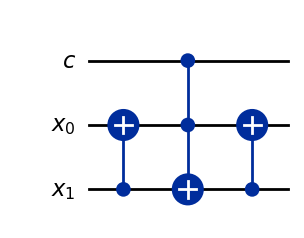

In [46]:
cswap().draw("mpl")

In [47]:
def shors_oracle_gate(a, N):

    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 2, name="b")

    oracle = QuantumCircuit(
        control_register, quantum_register, ancilla, name=f"Mult({a})_Mod({N})"
    )

    mod_mult_a_N = modular_mult(a, N)

    oracle.compose(mod_mult_a_N, inplace=True)
    for i in range(n):
        # oracle.cswap(0, i + 1, n + i + 1)
        oracle.compose(cswap(), [0, i + 1, n + i + 1], inplace=True)
        
    # is this necessary?  we can leave garbage in the ancilla, right?
    # b = inv_mod_N(a, N)
    # inv_mod_mult_a_N = modular_mult(N - b, N)
    inv_mod_mult_a_N = modular_mult(N - a, N).inverse()

    oracle.compose(inv_mod_mult_a_N, inplace=True)

    return oracle

Test:

In [48]:
a = 7
N = 15

c = 1
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
ancilla = QuantumRegister(size=n + 2, name="b")

oracle = QuantumCircuit(control_register, quantum_register, ancilla)

if c != 0:
 oracle.x(0)

oracle.compose(set_a(x, n), quantum_register, inplace=True)

oracle.compose(shors_oracle_gate(a, N), inplace=True)

psi = Statevector(oracle)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

if c == 0:
    print(res == 2 * x)
else:
    print((res - 1) // 2 == (a * x) % N)

True


Here is an implementation that does not require to compute inverses modulo $N$, but leaves garbage in the ancilla.

In [49]:
# garbage in ancilla
def shors_oracle_gate_2(a, N):

    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 2, name="b")

    oracle = QuantumCircuit(
        control_register, quantum_register, ancilla, name=f"Mult({a})_Mod({N})"
    )

    mod_mult_a_N = modular_mult(a, N)

    oracle.compose(mod_mult_a_N, inplace=True)
    for i in range(n):
        # oracle.cswap(0, i + 1, n + i + 1)
        oracle.compose(cswap(), [0, i + 1, n + i + 1], inplace=True)

    # # is this necessary?  we can leave garbage in the ancilla, right?
    # # b = inv_mod_N(a, N)
    # # inv_mod_mult_a_N = modular_mult(N - b, N)
    # inv_mod_mult_a_N = modular_mult(N - a, N).inverse()

    # oracle.compose(inv_mod_mult_a_N, inplace=True)

    return oracle

Test:

In [50]:
a = 8
N = 15

c = 1
x = 5

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
ancilla = QuantumRegister(size=n + 2, name="b")

oracle = QuantumCircuit(control_register, quantum_register, ancilla)

if c != 0:
 oracle.x(0)

oracle.compose(set_a(x, n), quantum_register, inplace=True)

oracle.compose(shors_oracle_gate(a, N), inplace=True)

psi = Statevector(oracle)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs))) % 2 ** (n + 1)  # drop the ancilla

if c == 0:
    print(res == 2 * x)
else:
    print((res - 1) // 2 == (a * x) % N)

True


In [51]:
a = 8
N = 15

c = 0
x = 5

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
ancilla = QuantumRegister(size=n + 2, name="b")

oracle = QuantumCircuit(control_register, quantum_register, ancilla)

if c != 0:
 oracle.x(0)

oracle.compose(set_a(x, n), quantum_register, inplace=True)

oracle.compose(shors_oracle_gate(a, N), inplace=True)

psi = Statevector(oracle)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs))) % 2 ** (n + 1)  # drop the ancilla

if c == 0:
    print(res == 2 * x)
else:
    print((res - 1) // 2 == (a * x) % N)

True


In [52]:
a = 8
N = 20

c = 1
x = 31


n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
ancilla = QuantumRegister(size=n + 2, name="b")

oracle = QuantumCircuit(control_register, quantum_register, ancilla)

if c != 0:
 oracle.x(0)

oracle.compose(set_a(x, n), quantum_register, inplace=True)

oracle.compose(shors_oracle_gate(a, N), inplace=True)

psi = Statevector(oracle)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs))) % 2 ** (n + 1)  # drop the ancilla

if c == 0:
    print(res == 2 * x)
else:
    print((res - 1) // 2 == (a * x) % N)

True


In [53]:
(res - 1) // 2, (a * x) % N

(8.0, 8)

In [54]:
# garbage in ancilla
def shors_oracle_gate_3(a, N):

    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 2, name="b")

    oracle = QuantumCircuit(
        control_register, quantum_register, ancilla, name=f"Mult({a})_Mod({N})"
    )

    mod_mult_a_N = modular_mult(a, N)

    oracle.compose(mod_mult_a_N, inplace=True)
    for i in range(n):
        # oracle.cswap(0, i + 1, n + i + 1)
        oracle.compose(cswap(), [0, i + 1, n + i + 1], inplace=True)

    # # is this necessary?  we can leave garbage in the ancilla, right?
    # # b = inv_mod_N(a, N)
    # # inv_mod_mult_a_N = modular_mult(N - b, N)
    # inv_mod_mult_a_N = modular_mult(N - a, N).inverse()

    # oracle.compose(inv_mod_mult_a_N, inplace=True)

    return oracle